# TD Count-Length Experimenter

This sandbox lets you sweep the **Setup bar count** and **Countdown bar count** thresholds parametrically, rather than being locked to the traditional 9-bar setup and 13-bar countdown.

The key question: *Are 9 and 13 actually optimal for these instruments, or is that Demark folklore?*

## What can be varied
| Parameter | Original | What it controls |
|---|---|---|
| `SETUP_COUNT` | 9 | Number of consecutive qualifying bars to trigger a setup |
| `COUNTDOWN_COUNT` | 13 | Number of qualifying countdown bars to trigger entry |
| `SETUP_LOOKBACK` | 4 | `close < close[N bars ago]` — the comparison offset |
| `COUNTDOWN_LOOKBACK` | 2 | `close <= low[N bars ago]` — the countdown comparison offset |
| `CARRY_WINDOW` | 63 (setup) / 126 (cd) | Max bars to hold a position |

## Cells
1. Installs & Imports
2. Config & Data
3. Parameterised TD Engine
4. Single-Config Backtest
5. Grid Search (sweep setup & countdown counts)
6. Results Dashboard
7. Best-Config Deep Dive
8. Comparison vs Original 9/13

# Cell 0 — Installs & Imports

In [1]:
# Cell 0: Installs & Imports
# ============================================================
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from itertools import product
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')
print("Imports complete")

Imports complete


# Cell 1 — Config & Data

In [2]:
# Cell 1: Config & Data
# ============================================================

TICKERS    = ['SPY', 'QQQ', 'IWM', 'TLT', 'HYG',
              'GLD', 'USO', 'UUP', 'EEM', 'VNQ', 'SLV', 'XLF', 'XLE']
START_DATE = '2015-01-01'
COST_BPS   = 5

# ── DEFAULT SINGLE-RUN PARAMETERS ─────────────────────────
# Edit these to test a specific configuration before running
# the full grid search.
DEFAULT_SETUP_COUNT       = 9    # Original: 9
DEFAULT_COUNTDOWN_COUNT   = 13   # Original: 13
DEFAULT_SETUP_LOOKBACK    = 4    # Original: 4   (close < close[-N])
DEFAULT_COUNTDOWN_LOOKBACK= 2    # Original: 2   (close <= low[-N])
DEFAULT_CARRY_SETUP       = 63   # Original: 63  bars to hold setup signal
DEFAULT_CARRY_COUNTDOWN   = 126  # Original: 126 bars to hold countdown signal

# ── GRID SEARCH RANGES ────────────────────────────────────
# The full grid search will test every combination of these.
# Tip: keep ranges small at first — a 5x5 grid over 13 tickers
# is already 325 backtests.
SETUP_COUNT_RANGE      = [7, 8, 9, 10, 11, 12]    # bars for setup completion
COUNTDOWN_COUNT_RANGE  = [9, 10, 11, 12, 13, 14, 15]  # bars for countdown
# The lookback and carry params are kept fixed during the grid
# search but you can uncomment ranges to sweep those too.
# SETUP_LOOKBACK_RANGE   = [3, 4, 5]
# COUNTDOWN_LOOKBACK_RANGE = [1, 2, 3]

# Fetch data
print("Fetching OHLCV...")
raw = yf.download(
    TICKERS,
    start      = START_DATE,
    auto_adjust= True,
    progress   = False
)

close   = raw['Close'].dropna(how='all').ffill(limit=3)
high    = raw['High'].dropna(how='all').ffill(limit=3)
low     = raw['Low'].dropna(how='all').ffill(limit=3)
returns = close.pct_change()

print(f"  Shape : {close.shape}")
print(f"  Range : {close.index[0].date()} -> {close.index[-1].date()}")
print("Data ready")

Fetching OHLCV...
  Shape : (2804, 13)
  Range : 2015-01-02 -> 2026-02-26
Data ready


# Cell 2 — Helper Functions

In [3]:
# Cell 2: Helper Functions
# ============================================================

def apply_costs(returns, position, cost_bps=5):
    cost     = cost_bps / 10_000
    turnover = position.diff().abs()
    return returns * position - turnover * cost


def performance_summary(r, name=''):
    r   = r.dropna()
    if len(r) == 0:
        return pd.Series({'Ann. Return': np.nan, 'Ann. Vol': np.nan,
                          'Sharpe': np.nan, 'Max DD': np.nan,
                          'Calmar': np.nan, 'Hit Rate': np.nan}, name=name)
    cum = (1 + r).cumprod()
    ann = 252
    ann_ret = (1 + r.mean()) ** ann - 1
    ann_vol = r.std() * np.sqrt(ann)
    sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
    roll_max = cum.cummax()
    mdd     = (cum / roll_max - 1).min()
    calmar  = ann_ret / abs(mdd) if mdd != 0 else np.nan
    hits    = (r > 0).mean()
    return pd.Series({
        'Ann. Return': ann_ret,
        'Ann. Vol':    ann_vol,
        'Sharpe':      sharpe,
        'Max DD':      mdd,
        'Calmar':      calmar,
        'Hit Rate':    hits,
    }, name=name)


def signal_density(sig_df):
    """Fraction of ticker-days where the signal is active."""
    return sig_df.mean().mean()


print("Helpers loaded")

Helpers loaded


# Cell 3 — Parameterised TD Engine

In [4]:
# Cell 3: Parameterised TD Engine
# ============================================================
# All count lengths are passed as arguments — nothing hardcoded.
#
# Key parameters explained:
#
#   setup_count       : How many consecutive qualifying bars needed
#                       to complete a setup (original = 9)
#
#   countdown_count   : How many qualifying countdown bars fire the
#                       entry signal (original = 13)
#
#   setup_lookback    : The 'N' in close < close[-N] for the setup
#                       condition (original = 4)
#
#   countdown_lookback: The 'N' in close <= low[-N] for the countdown
#                       condition (original = 2)
#
#   carry_setup       : Rolling window used to carry a setup signal
#                       forward until TDST exit (bars, original = 63)
#
#   carry_countdown   : Same for countdown signal (bars, original = 126)


def rolling_consecutive_count(cond: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a binary condition DataFrame into a consecutive-count
    DataFrame that resets to zero on False.
    """
    counts = pd.DataFrame(0, index=cond.index, columns=cond.columns)
    for col in cond.columns:
        s        = cond[col]
        group_id = (s == 0).cumsum()
        raw_count = s.groupby(group_id).cumsum()
        counts[col] = raw_count * s
    return counts


def compute_td_setup_param(
        close: pd.DataFrame,
        high: pd.DataFrame,
        low: pd.DataFrame,
        setup_count: int = 9,
        setup_lookback: int = 4) -> dict:
    """
    Parameterised TD Setup.

    Bullish: close < close[setup_lookback bars ago]  for setup_count consecutive bars
    Bearish: close > close[setup_lookback bars ago]  for setup_count consecutive bars

    Returns:
        bull_count       : running count per bar
        bear_count       : running count per bar
        bull_setup_signal: fires on bar == setup_count
        bear_setup_signal: fires on bar == setup_count
    """
    close_n = close.shift(setup_lookback)

    bull_cond = (close < close_n).astype(int)
    bear_cond = (close > close_n).astype(int)

    bull_count = rolling_consecutive_count(bull_cond)
    bear_count = rolling_consecutive_count(bear_cond)

    bull_signal = (bull_count == setup_count).astype(int)
    bear_signal = (bear_count == setup_count).astype(int)

    # TDST levels
    lowest_n  = low.rolling(setup_count).min()
    highest_n = high.rolling(setup_count).max()

    tdst_support = pd.DataFrame(np.nan, index=close.index, columns=close.columns)
    tdst_resistance = pd.DataFrame(np.nan, index=close.index, columns=close.columns)

    tdst_support[bull_signal == 1]    = lowest_n[bull_signal == 1]
    tdst_resistance[bear_signal == 1] = highest_n[bear_signal == 1]

    tdst_support    = tdst_support.ffill()
    tdst_resistance = tdst_resistance.ffill()

    tdst_long_valid  = (close > tdst_support).astype(int)
    tdst_short_valid = (close < tdst_resistance).astype(int)

    return {
        'bull_count':        bull_count,
        'bear_count':        bear_count,
        'bull_setup_signal': bull_signal,
        'bear_setup_signal': bear_signal,
        'tdst_support':      tdst_support,
        'tdst_resistance':   tdst_resistance,
        'tdst_long_valid':   tdst_long_valid,
        'tdst_short_valid':  tdst_short_valid,
    }


def compute_td_countdown_param(
        close: pd.DataFrame,
        high: pd.DataFrame,
        low: pd.DataFrame,
        bull_setup_signal: pd.DataFrame,
        bear_setup_signal: pd.DataFrame,
        countdown_count: int = 13,
        countdown_lookback: int = 2) -> dict:
    """
    Parameterised TD Countdown with recycling.

    Bullish condition: close <= low[countdown_lookback bars ago]
    Bearish condition: close >= high[countdown_lookback bars ago]

    countdown_count controls when the signal fires.
    Recycling: same-direction setup resets the countdown.
    Cancellation: opposite setup cancels the countdown.
    """
    low_n  = low.shift(countdown_lookback)
    high_n = high.shift(countdown_lookback)

    bull_cd_cond = (close <= low_n)
    bear_cd_cond = (close >= high_n)

    bull_cd_count  = pd.DataFrame(0, index=close.index, columns=close.columns)
    bear_cd_count  = pd.DataFrame(0, index=close.index, columns=close.columns)
    bull_cd_active = pd.DataFrame(0, index=close.index, columns=close.columns)
    bear_cd_active = pd.DataFrame(0, index=close.index, columns=close.columns)

    n_bars = len(close)

    for col in close.columns:
        # Bullish countdown
        in_cd = False
        b_count = 0
        b_counts = [0] * n_bars
        b_active = [0] * n_bars

        for i in range(n_bars):
            if bull_setup_signal[col].iloc[i] == 1:
                b_count = 0
                in_cd   = True
            if bear_setup_signal[col].iloc[i] == 1:
                in_cd   = False
                b_count = 0
            if in_cd and b_count < countdown_count:
                if bull_cd_cond[col].iloc[i]:
                    b_count += 1
            b_counts[i] = b_count if in_cd else 0
            b_active[i] = 1     if in_cd else 0

        bull_cd_count[col]  = b_counts
        bull_cd_active[col] = b_active

        # Bearish countdown
        in_cd   = False
        r_count = 0
        r_counts = [0] * n_bars
        r_active = [0] * n_bars

        for i in range(n_bars):
            if bear_setup_signal[col].iloc[i] == 1:
                r_count = 0
                in_cd   = True
            if bull_setup_signal[col].iloc[i] == 1:
                in_cd   = False
                r_count = 0
            if in_cd and r_count < countdown_count:
                if bear_cd_cond[col].iloc[i]:
                    r_count += 1
            r_counts[i] = r_count if in_cd else 0
            r_active[i] = 1     if in_cd else 0

        bear_cd_count[col]  = r_counts
        bear_cd_active[col] = r_active

    bull_cd_signal = (bull_cd_count == countdown_count).astype(int)
    bear_cd_signal = (bear_cd_count == countdown_count).astype(int)

    return {
        'bull_cd_count':  bull_cd_count,
        'bear_cd_count':  bear_cd_count,
        'bull_cd_signal': bull_cd_signal,
        'bear_cd_signal': bear_cd_signal,
        'bull_cd_active': bull_cd_active,
        'bear_cd_active': bear_cd_active,
    }


print("Parameterised TD engine loaded")

Parameterised TD engine loaded


# Cell 4 — Signal Builders & Backtest Function

In [5]:
# Cell 4: Signal Builders & Single-Config Backtest
# ============================================================

def build_signals_for_config(
        close, high, low,
        setup_count       = 9,
        countdown_count   = 13,
        setup_lookback    = 4,
        countdown_lookback= 2,
        carry_setup       = 63,
        carry_countdown   = 126):
    """
    Build all TD signals for a given parameter config.
    Returns a dict with long/short signals for:
      - setup only (V1)
      - countdown only (V2)
      - both combined (V3)
    """
    td = compute_td_setup_param(
        close, high, low,
        setup_count=setup_count,
        setup_lookback=setup_lookback)

    cd = compute_td_countdown_param(
        close, high, low,
        td['bull_setup_signal'],
        td['bear_setup_signal'],
        countdown_count=countdown_count,
        countdown_lookback=countdown_lookback)

    # ── V1: Setup only ─────────────────────────────────────
    long_entry_v1 = (
        (td['bull_setup_signal'] == 1) &
        (td['tdst_long_valid'] == 1)
    ).astype(int)
    long_carried_v1 = long_entry_v1.rolling(carry_setup, min_periods=1).max()
    v1_long  = (long_carried_v1 * td['tdst_long_valid']).clip(0, 1).shift(1).fillna(0)

    short_entry_v1 = (
        (td['bear_setup_signal'] == 1) &
        (td['tdst_short_valid'] == 1)
    ).astype(int)
    short_carried_v1 = short_entry_v1.rolling(carry_setup, min_periods=1).max()
    v1_short = (short_carried_v1 * td['tdst_short_valid']).clip(0, 1).shift(1).fillna(0)

    # ── V2: Countdown only ─────────────────────────────────
    long_entry_v2 = (
        (cd['bull_cd_signal'] == 1) &
        (td['tdst_long_valid'] == 1)
    ).astype(int)
    long_carried_v2 = long_entry_v2.rolling(carry_countdown, min_periods=1).max()
    v2_long  = (long_carried_v2 * td['tdst_long_valid']).clip(0, 1).shift(1).fillna(0)

    short_entry_v2 = (
        (cd['bear_cd_signal'] == 1) &
        (td['tdst_short_valid'] == 1)
    ).astype(int)
    short_carried_v2 = short_entry_v2.rolling(carry_countdown, min_periods=1).max()
    v2_short = (short_carried_v2 * td['tdst_short_valid']).clip(0, 1).shift(1).fillna(0)

    # ── V3: Combined 50/50 ────────────────────────────────
    v3_long = (
        (long_carried_v1 * 0.5 + long_carried_v2 * 0.5) *
        td['tdst_long_valid']
    ).clip(0, 1).shift(1).fillna(0)

    v3_short = (
        (short_carried_v1 * 0.5 + short_carried_v2 * 0.5) *
        td['tdst_short_valid']
    ).clip(0, 1).shift(1).fillna(0)

    return {
        'v1_long': v1_long,  'v1_short': v1_short,
        'v2_long': v2_long,  'v2_short': v2_short,
        'v3_long': v3_long,  'v3_short': v3_short,
        'bull_count':    td['bull_count'],
        'bear_count':    td['bear_count'],
        'bull_cd_count': cd['bull_cd_count'],
        'bear_cd_count': cd['bear_cd_count'],
    }


def backtest_config(
        close, high, low, returns,
        setup_count=9,
        countdown_count=13,
        setup_lookback=4,
        countdown_lookback=2,
        carry_setup=63,
        carry_countdown=126,
        cost_bps=5,
        variant='v1'):
    """
    Run a full equal-weight universe backtest for one parameter config.
    Returns a dict of performance metrics plus the raw return Series.

    variant: 'v1' (setup only), 'v2' (countdown only), 'v3' (combined)
    """
    sigs = build_signals_for_config(
        close, high, low,
        setup_count=setup_count,
        countdown_count=countdown_count,
        setup_lookback=setup_lookback,
        countdown_lookback=countdown_lookback,
        carry_setup=carry_setup,
        carry_countdown=carry_countdown)

    long_sig  = sigs[f'{variant}_long']
    short_sig = sigs[f'{variant}_short']

    # Long side
    lp     = long_sig.reindex(returns.index).fillna(0)
    ln     = apply_costs(returns, lp, cost_bps)
    n_long = long_sig.sum(axis=1).replace(0, np.nan)
    l_pnl  = (ln * lp).sum(axis=1)
    l_ret  = (l_pnl / n_long).fillna(0)

    # Short side
    sp      = short_sig.reindex(returns.index).fillna(0) * -1
    sn      = apply_costs(returns, sp, cost_bps)
    n_short = short_sig.sum(axis=1).replace(0, np.nan)
    s_pnl   = (sn * sp).sum(axis=1)
    s_ret   = (s_pnl / n_short).fillna(0)

    combined = ((l_ret + s_ret) / 2)

    stats = performance_summary(combined)
    stats['Signal Density Long']  = signal_density(long_sig)
    stats['Signal Density Short'] = signal_density(short_sig)
    stats['Setup Count']          = setup_count
    stats['Countdown Count']      = countdown_count
    stats['Setup Lookback']       = setup_lookback
    stats['Countdown Lookback']   = countdown_lookback
    stats['Variant']              = variant
    stats['ret_series']           = combined

    return stats


print("Signal builders & backtest function loaded")

Signal builders & backtest function loaded


# Cell 5 — Single Config Run

Run a single configuration to validate the engine before launching the grid search.

Running single config: Setup=9, Countdown=13, SetupLB=4, CDLB=2, Variant=v1

Done in 1.7s

SINGLE CONFIG RESULTS
  Ann. Return                   : 0.1141
  Ann. Vol                      : 0.1404
  Sharpe                        : 0.8125
  Max DD                        : -0.2883
  Calmar                        : 0.3957
  Hit Rate                      : 0.5403
  Signal Density Long           : 0.3748
  Signal Density Short          : 0.4398
  Setup Count                   : 9.0000
  Countdown Count               : 13.0000
  Setup Lookback                : 4.0000
  Countdown Lookback            : 2.0000
  Variant                       : v1


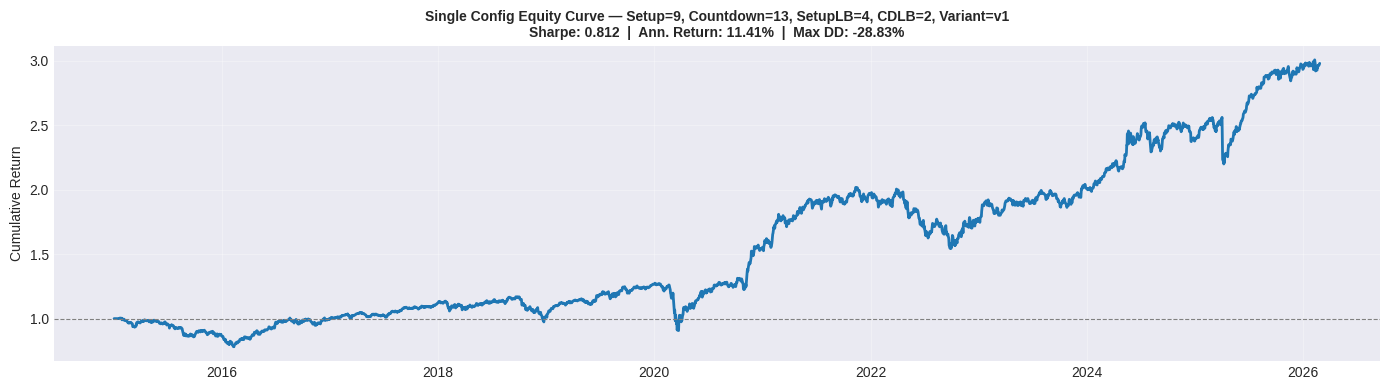

In [6]:
# Cell 5: Single Config Run
# ============================================================
# ── CONTROLS — edit these to test a specific config ────────
SINGLE_SETUP_COUNT      = DEFAULT_SETUP_COUNT        # bars
SINGLE_COUNTDOWN_COUNT  = DEFAULT_COUNTDOWN_COUNT    # bars
SINGLE_SETUP_LOOKBACK   = DEFAULT_SETUP_LOOKBACK     # bars
SINGLE_CD_LOOKBACK      = DEFAULT_COUNTDOWN_LOOKBACK # bars
SINGLE_CARRY_SETUP      = DEFAULT_CARRY_SETUP        # bars
SINGLE_CARRY_COUNTDOWN  = DEFAULT_CARRY_COUNTDOWN    # bars
SINGLE_VARIANT          = 'v1'  # 'v1', 'v2', or 'v3'
# ──────────────────────────────────────────────────────────

import time
print(f"Running single config: Setup={SINGLE_SETUP_COUNT}, "
      f"Countdown={SINGLE_COUNTDOWN_COUNT}, "
      f"SetupLB={SINGLE_SETUP_LOOKBACK}, "
      f"CDLB={SINGLE_CD_LOOKBACK}, "
      f"Variant={SINGLE_VARIANT}")

t0 = time.time()
single_result = backtest_config(
    close, high, low, returns,
    setup_count        = SINGLE_SETUP_COUNT,
    countdown_count    = SINGLE_COUNTDOWN_COUNT,
    setup_lookback     = SINGLE_SETUP_LOOKBACK,
    countdown_lookback = SINGLE_CD_LOOKBACK,
    carry_setup        = SINGLE_CARRY_SETUP,
    carry_countdown    = SINGLE_CARRY_COUNTDOWN,
    cost_bps           = COST_BPS,
    variant            = SINGLE_VARIANT,
)
elapsed = time.time() - t0
print(f"\nDone in {elapsed:.1f}s")

print("\n" + "=" * 50)
print("SINGLE CONFIG RESULTS")
print("=" * 50)
for k, v in single_result.items():
    if k == 'ret_series':
        continue
    if isinstance(v, float):
        print(f"  {k:30s}: {v:.4f}")
    else:
        print(f"  {k:30s}: {v}")

# Equity curve for this config
fig, ax = plt.subplots(figsize=(14, 4))
cum = (1 + single_result['ret_series']).cumprod()
ax.plot(cum.index, cum, color='#1f77b4', linewidth=2)
ax.axhline(1, color='grey', linestyle='--', linewidth=0.8)
ax.set_title(
    f'Single Config Equity Curve — '
    f'Setup={SINGLE_SETUP_COUNT}, Countdown={SINGLE_COUNTDOWN_COUNT}, '
    f'SetupLB={SINGLE_SETUP_LOOKBACK}, CDLB={SINGLE_CD_LOOKBACK}, '
    f'Variant={SINGLE_VARIANT}\n'
    f'Sharpe: {single_result["Sharpe"]:.3f}  |  '
    f'Ann. Return: {single_result["Ann. Return"]:.2%}  |  '
    f'Max DD: {single_result["Max DD"]:.2%}',
    fontweight='bold', fontsize=10)
ax.set_ylabel('Cumulative Return')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('single_config.png', dpi=150)
plt.show()

# Cell 6 — Grid Search

Sweeps all combinations of `SETUP_COUNT_RANGE × COUNTDOWN_COUNT_RANGE`.

⚠️ **Runtime warning**: Each iteration requires a countdown loop per ticker. A 6×7 grid = 42 configs × ~5-15s each. Expect 5–10 minutes for the full grid.

In [7]:
# Cell 6: Grid Search
# ============================================================
# ── CONTROLS ──────────────────────────────────────────────
GRID_VARIANTS        = ['v1', 'v2', 'v3']  # which variants to run
GRID_SETUP_LOOKBACK  = DEFAULT_SETUP_LOOKBACK
GRID_CD_LOOKBACK     = DEFAULT_COUNTDOWN_LOOKBACK
GRID_CARRY_SETUP     = DEFAULT_CARRY_SETUP
GRID_CARRY_COUNTDOWN = DEFAULT_CARRY_COUNTDOWN
# ──────────────────────────────────────────────────────────

import time

grid_combos = list(product(SETUP_COUNT_RANGE, COUNTDOWN_COUNT_RANGE))
total_runs  = len(grid_combos) * len(GRID_VARIANTS)

print(f"Grid search: {len(SETUP_COUNT_RANGE)} setup counts × "
      f"{len(COUNTDOWN_COUNT_RANGE)} countdown counts × "
      f"{len(GRID_VARIANTS)} variants = {total_runs} configs")
print(f"Setup range:    {SETUP_COUNT_RANGE}")
print(f"Countdown range:{COUNTDOWN_COUNT_RANGE}")
print(f"Variants:       {GRID_VARIANTS}")

grid_results = []
t_start = time.time()

for run_idx, (sc, cc) in enumerate(grid_combos):
    t_iter = time.time()
    for variant in GRID_VARIANTS:
        result = backtest_config(
            close, high, low, returns,
            setup_count        = sc,
            countdown_count    = cc,
            setup_lookback     = GRID_SETUP_LOOKBACK,
            countdown_lookback = GRID_CD_LOOKBACK,
            carry_setup        = GRID_CARRY_SETUP,
            carry_countdown    = GRID_CARRY_COUNTDOWN,
            cost_bps           = COST_BPS,
            variant            = variant,
        )
        grid_results.append(result)

    elapsed = time.time() - t_start
    done    = run_idx + 1
    remaining = (elapsed / done) * (len(grid_combos) - done)
    print(f"  [{done:3d}/{len(grid_combos)}] SC={sc:2d} CC={cc:2d}  "
          f"({time.time()-t_iter:.1f}s)  "
          f"ETA: {remaining/60:.1f}m")

total_time = time.time() - t_start
print(f"\nGrid search complete in {total_time/60:.1f} minutes")
print(f"{len(grid_results)} results")

# Build results table
grid_df = pd.DataFrame([
    {k: v for k, v in r.items() if k != 'ret_series'}
    for r in grid_results
])

grid_df_sorted = grid_df.sort_values('Sharpe', ascending=False)
print("\nTop 20 configurations by Sharpe:")
print(grid_df_sorted[
    ['Variant', 'Setup Count', 'Countdown Count',
     'Sharpe', 'Ann. Return', 'Max DD', 'Calmar',
     'Signal Density Long', 'Signal Density Short']
].head(20).round(3).to_string())

Grid search: 6 setup counts × 7 countdown counts × 3 variants = 126 configs
Setup range:    [7, 8, 9, 10, 11, 12]
Countdown range:[9, 10, 11, 12, 13, 14, 15]
Variants:       ['v1', 'v2', 'v3']
  [  1/42] SC= 7 CC= 9  (4.2s)  ETA: 2.8m
  [  2/42] SC= 7 CC=10  (4.1s)  ETA: 2.8m
  [  3/42] SC= 7 CC=11  (5.5s)  ETA: 3.0m
  [  4/42] SC= 7 CC=12  (4.3s)  ETA: 2.9m
  [  5/42] SC= 7 CC=13  (4.8s)  ETA: 2.8m
  [  6/42] SC= 7 CC=14  (4.9s)  ETA: 2.8m
  [  7/42] SC= 7 CC=15  (4.2s)  ETA: 2.7m
  [  8/42] SC= 8 CC= 9  (5.1s)  ETA: 2.6m
  [  9/42] SC= 8 CC=10  (4.3s)  ETA: 2.5m
  [ 10/42] SC= 8 CC=11  (4.1s)  ETA: 2.4m
  [ 11/42] SC= 8 CC=12  (5.4s)  ETA: 2.4m
  [ 12/42] SC= 8 CC=13  (4.1s)  ETA: 2.3m
  [ 13/42] SC= 8 CC=14  (4.2s)  ETA: 2.2m
  [ 14/42] SC= 8 CC=15  (5.5s)  ETA: 2.2m
  [ 15/42] SC= 9 CC= 9  (4.0s)  ETA: 2.1m
  [ 16/42] SC= 9 CC=10  (4.0s)  ETA: 2.0m
  [ 17/42] SC= 9 CC=11  (5.3s)  ETA: 1.9m
  [ 18/42] SC= 9 CC=12  (4.0s)  ETA: 1.8m
  [ 19/42] SC= 9 CC=13  (4.1s)  ETA: 1.7m
  [ 20/42

# Cell 7 — Results Heatmaps

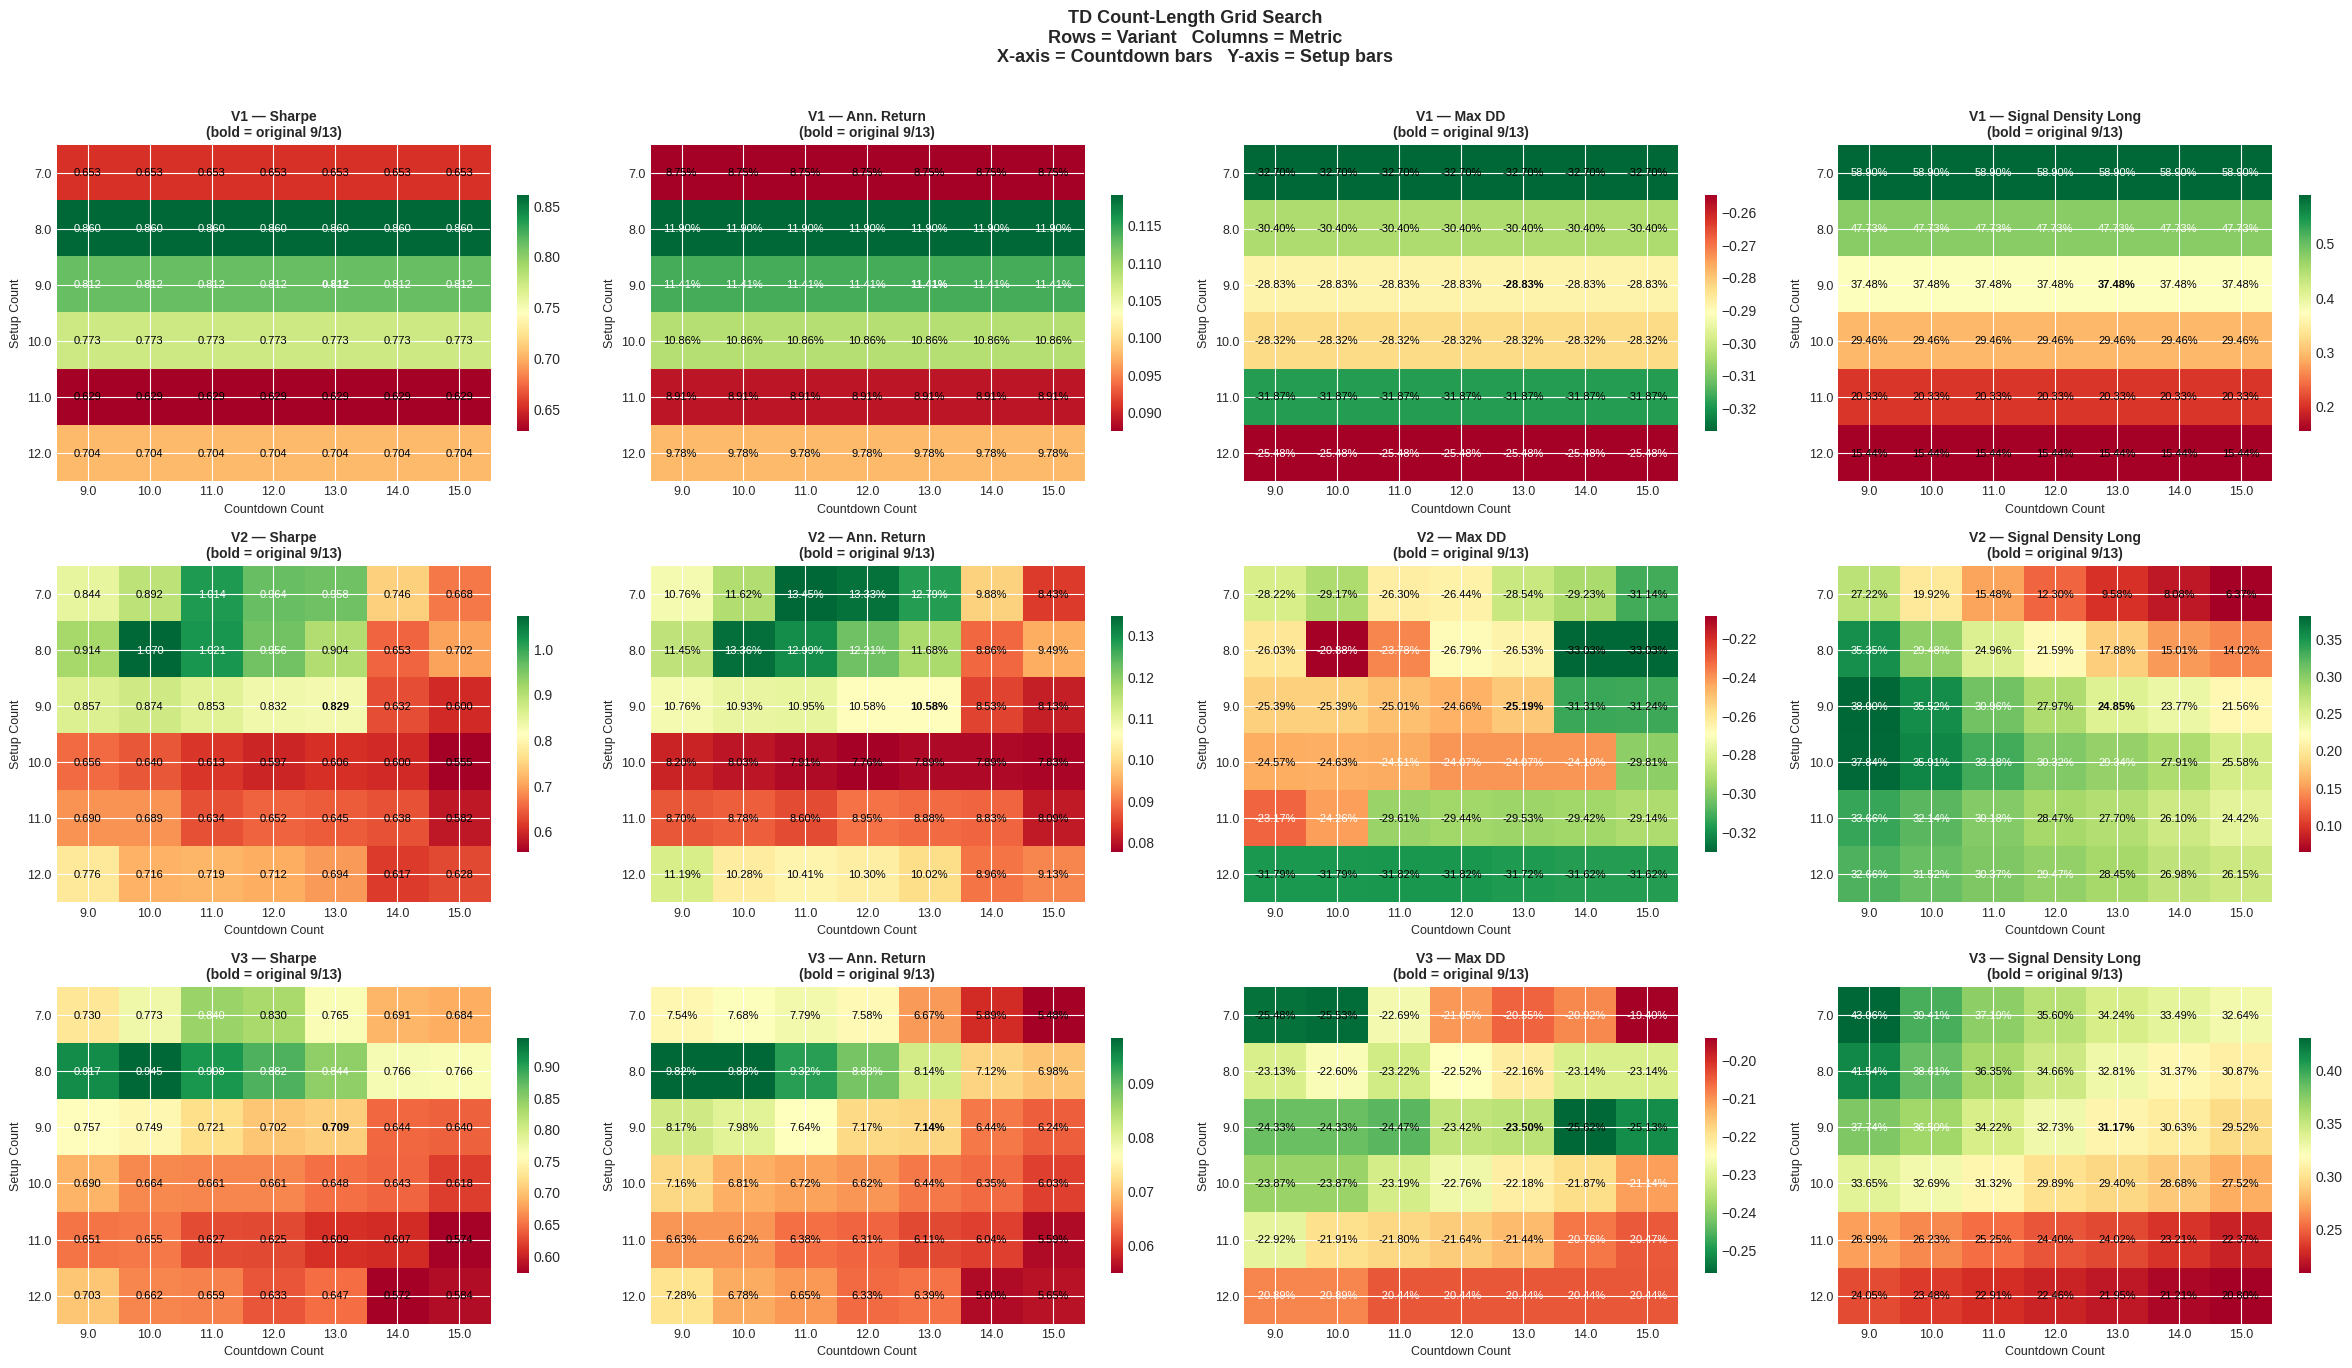

Saved: td_grid_heatmaps.png


In [8]:
# Cell 7: Results Heatmaps
# ============================================================
# Show Sharpe, Ann. Return, Max DD, and Signal Density
# as 2D heatmaps across Setup Count x Countdown Count
# for each variant.

HEATMAP_METRIC = 'Sharpe'  # Change to 'Ann. Return', 'Max DD', 'Calmar', etc.

variants = grid_df['Variant'].unique()
n_variants = len(variants)
metrics_to_show = ['Sharpe', 'Ann. Return', 'Max DD', 'Signal Density Long']

fig, axes = plt.subplots(
    n_variants, len(metrics_to_show),
    figsize=(6 * len(metrics_to_show), 4.5 * n_variants))

for row, variant in enumerate(variants):
    vdf = grid_df[grid_df['Variant'] == variant]

    for col, metric in enumerate(metrics_to_show):
        ax = axes[row, col] if n_variants > 1 else axes[col]

        pivot = vdf.pivot(
            index='Setup Count',
            columns='Countdown Count',
            values=metric
        )

        vmin = pivot.values.min()
        vmax = pivot.values.max()

        # For Max DD lower is better — flip the colormap
        cmap = 'RdYlGn' if metric != 'Max DD' else 'RdYlGn_r'

        im = ax.imshow(
            pivot.values,
            cmap=cmap,
            aspect='auto',
            vmin=vmin, vmax=vmax,
            interpolation='nearest'
        )

        ax.set_xticks(range(len(pivot.columns)))
        ax.set_xticklabels(pivot.columns, fontsize=9)
        ax.set_yticks(range(len(pivot.index)))
        ax.set_yticklabels(pivot.index, fontsize=9)

        # Annotate cells
        for i in range(len(pivot.index)):
            for j in range(len(pivot.columns)):
                val = pivot.iloc[i, j]
                if not np.isnan(val):
                    # Highlight the original 9/13 cell
                    sc_val = pivot.index[i]
                    cc_val = pivot.columns[j]
                    is_orig = (sc_val == 9 and cc_val == 13)
                    fmt = f'{val:.3f}' if metric in ['Sharpe', 'Calmar'] else f'{val:.2%}'
                    ax.text(
                        j, i, fmt,
                        ha='center', va='center',
                        fontsize=8,
                        fontweight='bold' if is_orig else 'normal',
                        color='white' if abs((val - vmin) / (vmax - vmin + 1e-8)) > 0.7 else 'black'
                    )

        plt.colorbar(im, ax=ax, shrink=0.7)
        ax.set_xlabel('Countdown Count', fontsize=9)
        ax.set_ylabel('Setup Count', fontsize=9)
        ax.set_title(f'{variant.upper()} — {metric}\n(bold = original 9/13)',
                     fontweight='bold', fontsize=10)

fig.suptitle(
    'TD Count-Length Grid Search\n'
    'Rows = Variant   Columns = Metric\n'
    'X-axis = Countdown bars   Y-axis = Setup bars',
    fontsize=13, fontweight='bold', y=1.01)

plt.tight_layout()
plt.savefig('td_grid_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: td_grid_heatmaps.png")

# Cell 8 — Sharpe Profiles (line plots across count ranges)

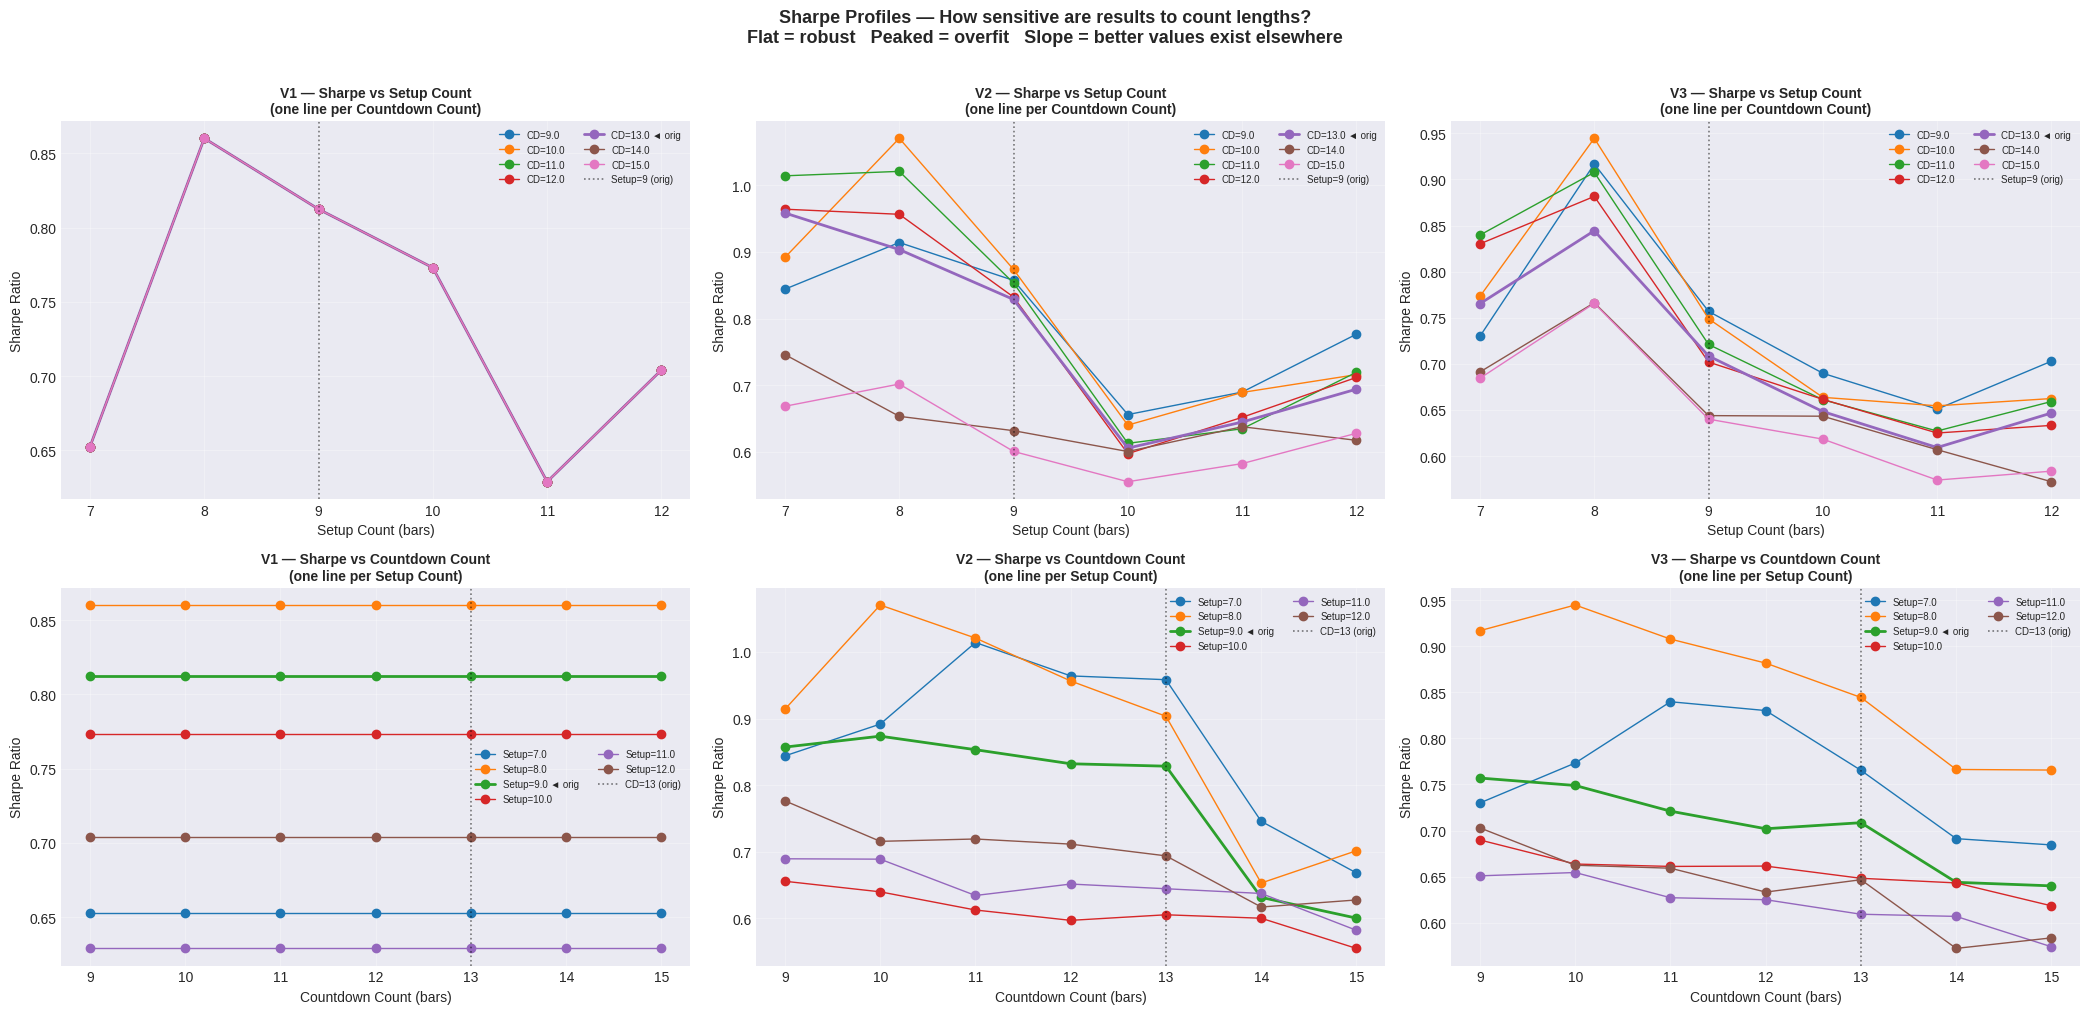

Saved: td_sharpe_profiles.png


In [9]:
# Cell 8: Sharpe Profiles
# ============================================================
# For each variant, show how Sharpe varies as you slide
# setup count (fixing countdown) and vice versa.
# This reveals whether 9 and 13 sit at a local maximum
# or on a slope.

fig, axes = plt.subplots(2, len(variants), figsize=(7 * len(variants), 10))

for col, variant in enumerate(variants):
    vdf = grid_df[grid_df['Variant'] == variant]

    # ── Top row: Sharpe vs Setup Count (one line per Countdown Count)
    ax = axes[0, col] if len(variants) > 1 else axes[0]
    for cc in sorted(vdf['Countdown Count'].unique()):
        sub = vdf[vdf['Countdown Count'] == cc].sort_values('Setup Count')
        is_orig_cc = (cc == 13)
        ax.plot(
            sub['Setup Count'],
            sub['Sharpe'],
            marker='o',
            linewidth=2.0 if is_orig_cc else 1.0,
            label=f'CD={cc}' + (' ◄ orig' if is_orig_cc else '')
        )
    ax.axvline(9, color='black', linestyle=':', linewidth=1.2, alpha=0.5, label='Setup=9 (orig)')
    ax.set_xlabel('Setup Count (bars)', fontsize=10)
    ax.set_ylabel('Sharpe Ratio', fontsize=10)
    ax.set_title(f'{variant.upper()} — Sharpe vs Setup Count\n(one line per Countdown Count)',
                 fontweight='bold', fontsize=10)
    ax.legend(fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

    # ── Bottom row: Sharpe vs Countdown Count (one line per Setup Count)
    ax = axes[1, col] if len(variants) > 1 else axes[1]
    for sc in sorted(vdf['Setup Count'].unique()):
        sub = vdf[vdf['Setup Count'] == sc].sort_values('Countdown Count')
        is_orig_sc = (sc == 9)
        ax.plot(
            sub['Countdown Count'],
            sub['Sharpe'],
            marker='o',
            linewidth=2.0 if is_orig_sc else 1.0,
            label=f'Setup={sc}' + (' ◄ orig' if is_orig_sc else '')
        )
    ax.axvline(13, color='black', linestyle=':', linewidth=1.2, alpha=0.5, label='CD=13 (orig)')
    ax.set_xlabel('Countdown Count (bars)', fontsize=10)
    ax.set_ylabel('Sharpe Ratio', fontsize=10)
    ax.set_title(f'{variant.upper()} — Sharpe vs Countdown Count\n(one line per Setup Count)',
                 fontweight='bold', fontsize=10)
    ax.legend(fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

fig.suptitle(
    'Sharpe Profiles — How sensitive are results to count lengths?\n'
    'Flat = robust   Peaked = overfit   Slope = better values exist elsewhere',
    fontsize=13, fontweight='bold', y=1.01)

plt.tight_layout()
plt.savefig('td_sharpe_profiles.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: td_sharpe_profiles.png")

# Cell 9 — Best Config Deep Dive

Best config for V1:
  Setup Count    : 8
  Countdown Count: 11
  Sharpe         : 0.860
  Ann. Return    : 11.90%
  Max DD         : -30.40%

Original 9/13 config for V1:
  Sharpe     : 0.812
  Ann. Return: 11.41%
  Max DD     : -28.83%


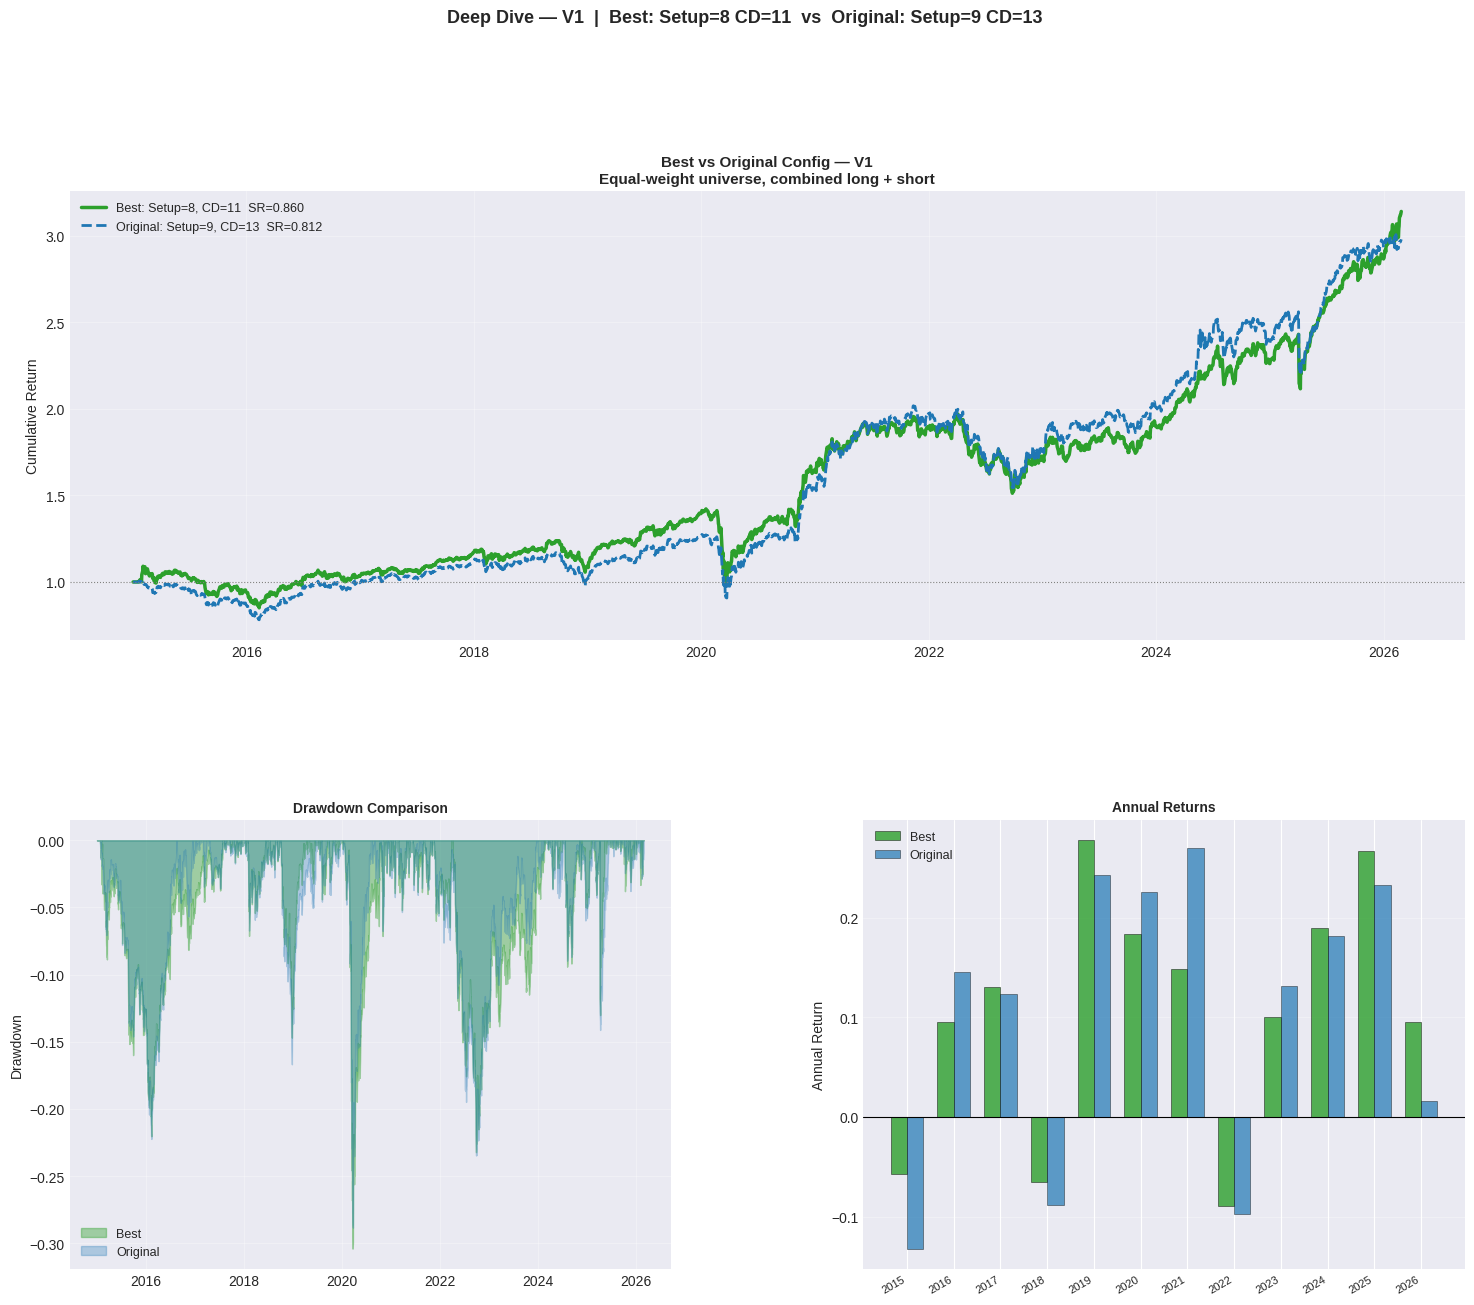

Saved: td_best_vs_original.png


In [10]:
# Cell 9: Best Config Deep Dive
# ============================================================
# Compares the best-found config against the original 9/13.
# Shows equity curves, drawdowns, and per-ticker Sharpe.

# ── CONTROLS ──────────────────────────────────────────────
DEEP_DIVE_VARIANT = 'v1'  # which variant to compare
# ──────────────────────────────────────────────────────────

# Find best config for the chosen variant
vdf_best = grid_df[
    (grid_df['Variant'] == DEEP_DIVE_VARIANT) &
    grid_df['Sharpe'].notna()
].sort_values('Sharpe', ascending=False)

best_row = vdf_best.iloc[0]
best_sc  = int(best_row['Setup Count'])
best_cc  = int(best_row['Countdown Count'])

print(f"Best config for {DEEP_DIVE_VARIANT.upper()}:")
print(f"  Setup Count    : {best_sc}")
print(f"  Countdown Count: {best_cc}")
print(f"  Sharpe         : {best_row['Sharpe']:.3f}")
print(f"  Ann. Return    : {best_row['Ann. Return']:.2%}")
print(f"  Max DD         : {best_row['Max DD']:.2%}")

# Retrieve the stored return series
best_ret_idx = next(
    i for i, r in enumerate(grid_results)
    if (r['Variant'] == DEEP_DIVE_VARIANT and
        r['Setup Count'] == best_sc and
        r['Countdown Count'] == best_cc)
)
best_ret = grid_results[best_ret_idx]['ret_series']

# Original 9/13 return series
orig_idx = next(
    i for i, r in enumerate(grid_results)
    if (r['Variant'] == DEEP_DIVE_VARIANT and
        r['Setup Count'] == 9 and
        r['Countdown Count'] == 13)
)
orig_ret = grid_results[orig_idx]['ret_series']
orig_stats = grid_results[orig_idx]

print(f"\nOriginal 9/13 config for {DEEP_DIVE_VARIANT.upper()}:")
print(f"  Sharpe     : {orig_stats['Sharpe']:.3f}")
print(f"  Ann. Return: {orig_stats['Ann. Return']:.2%}")
print(f"  Max DD     : {orig_stats['Max DD']:.2%}")

# ── Dashboard ─────────────────────────────────────────────
fig = plt.figure(figsize=(18, 14))
gs  = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.32)

# Panel 1: Equity curves
ax1 = fig.add_subplot(gs[0, :])
cum_best = (1 + best_ret).cumprod()
cum_orig = (1 + orig_ret).cumprod()
ax1.plot(cum_best.index, cum_best,
         color='#2ca02c', linewidth=2.5,
         label=f'Best: Setup={best_sc}, CD={best_cc}  SR={best_row["Sharpe"]:.3f}')
ax1.plot(cum_orig.index, cum_orig,
         color='#1f77b4', linewidth=2.0,
         linestyle='--',
         label=f'Original: Setup=9, CD=13  SR={orig_stats["Sharpe"]:.3f}')
ax1.axhline(1, color='grey', linestyle=':', linewidth=0.8)
ax1.set_title(
    f'Best vs Original Config — {DEEP_DIVE_VARIANT.upper()}\n'
    f'Equal-weight universe, combined long + short',
    fontweight='bold', fontsize=11)
ax1.set_ylabel('Cumulative Return')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Panel 2: Drawdown comparison
ax2 = fig.add_subplot(gs[1, 0])
dd_best = cum_best / cum_best.cummax() - 1
dd_orig = cum_orig / cum_orig.cummax() - 1
ax2.fill_between(dd_best.index, dd_best, 0, alpha=0.4, color='#2ca02c', label='Best')
ax2.fill_between(dd_orig.index, dd_orig, 0, alpha=0.3, color='#1f77b4', label='Original')
ax2.set_title('Drawdown Comparison', fontweight='bold', fontsize=10)
ax2.set_ylabel('Drawdown')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Panel 3: Annual returns comparison
ax3 = fig.add_subplot(gs[1, 1])
ann_best = best_ret.resample('YE').apply(lambda x: (1+x).prod()-1)
ann_orig = orig_ret.resample('YE').apply(lambda x: (1+x).prod()-1)
years    = ann_best.index.year
x        = np.arange(len(years))
w        = 0.35
ax3.bar(x - w/2, ann_best.values, w, label='Best', color='#2ca02c', alpha=0.8, edgecolor='black', linewidth=0.4)
ax3.bar(x + w/2, ann_orig.values, w, label='Original', color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=0.4)
ax3.axhline(0, color='black', linewidth=0.8)
ax3.set_xticks(x)
ax3.set_xticklabels(years, rotation=30, ha='right', fontsize=8)
ax3.set_title('Annual Returns', fontweight='bold', fontsize=10)
ax3.set_ylabel('Annual Return')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    f'Deep Dive — {DEEP_DIVE_VARIANT.upper()}  |  '
    f'Best: Setup={best_sc} CD={best_cc}  vs  Original: Setup=9 CD=13',
    fontsize=13, fontweight='bold', y=1.01)

plt.savefig('td_best_vs_original.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: td_best_vs_original.png")

# Cell 10 — Per-Ticker Breakdown

Computing per-ticker Sharpe for best and original configs...

Per-Ticker Sharpe — Best vs Original:
     Best (SC=8,CC=11)  Original (SC=9,CC=13)   Delta
SPY             0.8540                 0.6570  0.1980
QQQ             0.8600                 0.6990  0.1610
IWM             0.5650                 0.5160  0.0490
TLT            -0.0900                 0.0840 -0.1730
HYG             0.3630                 0.4690 -0.1060
GLD             0.8980                 0.5700  0.3280
USO             0.2890                 0.2470  0.0420
UUP             0.6350                 0.4810  0.1540
EEM             0.1210                 0.0930  0.0280
VNQ             0.3850                 0.3610  0.0240
SLV             0.3980                 0.4560 -0.0570
XLF             0.4920                 0.3990  0.0930
XLE             0.4100                 0.4150 -0.0040


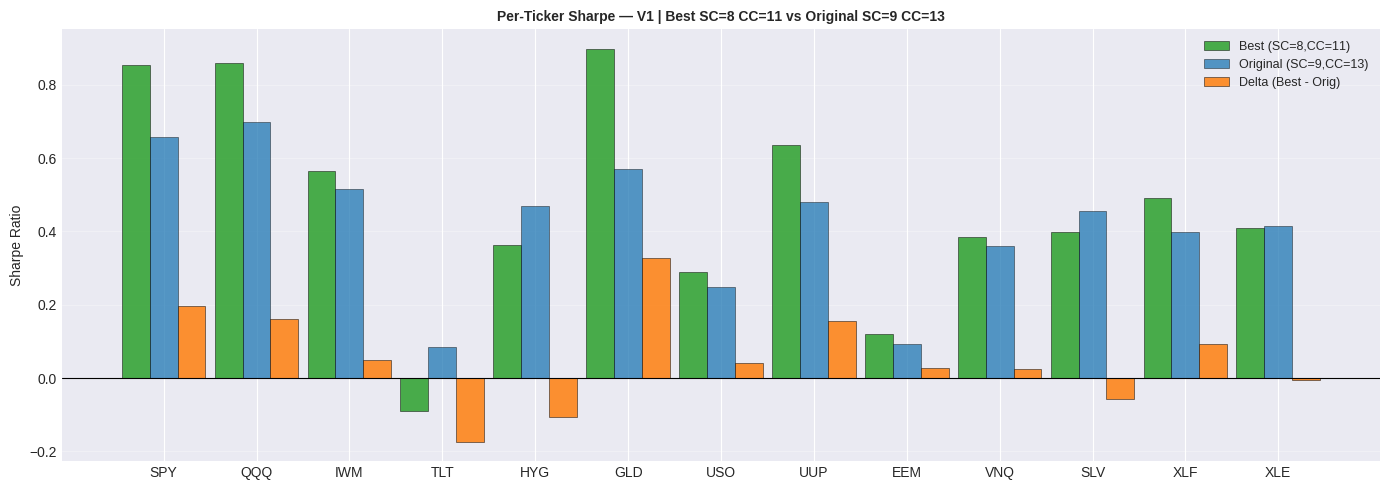

Saved: td_per_ticker_comparison.png


In [11]:
# Cell 10: Per-Ticker Breakdown
# ============================================================
# Compare per-ticker Sharpe between best and original config.
# Reveals which instruments drive the improvement.

# ── CONTROLS ──────────────────────────────────────────────
TICKER_BREAKDOWN_VARIANT = DEEP_DIVE_VARIANT
# ──────────────────────────────────────────────────────────

def per_ticker_sharpe_for_config(
        close, high, low, returns,
        setup_count, countdown_count,
        setup_lookback=4,
        countdown_lookback=2,
        carry_setup=63,
        carry_countdown=126,
        cost_bps=5,
        variant='v1'):
    """Compute Sharpe per ticker for a given config."""
    sigs = build_signals_for_config(
        close, high, low,
        setup_count=setup_count,
        countdown_count=countdown_count,
        setup_lookback=setup_lookback,
        countdown_lookback=countdown_lookback,
        carry_setup=carry_setup,
        carry_countdown=carry_countdown)

    long_sig  = sigs[f'{variant}_long']
    short_sig = sigs[f'{variant}_short']

    sharpes = {}
    for ticker in TICKERS:
        if ticker not in close.columns:
            continue
        lp  = long_sig[ticker].reindex(returns.index).fillna(0)
        sp  = short_sig[ticker].reindex(returns.index).fillna(0) * -1
        ln  = apply_costs(returns[[ticker]], lp.to_frame(), cost_bps)[ticker]
        sn  = apply_costs(returns[[ticker]], sp.to_frame(), cost_bps)[ticker]
        lr  = (ln * lp).fillna(0)
        sr  = (sn * sp).fillna(0)
        cr  = ((lr + sr) / 2).dropna()
        mu  = cr.mean()
        sd  = cr.std()
        sharpes[ticker] = (mu / sd * np.sqrt(252) if sd > 0 else np.nan)
    return pd.Series(sharpes)


print("Computing per-ticker Sharpe for best and original configs...")
best_ticker_sr = per_ticker_sharpe_for_config(
    close, high, low, returns,
    setup_count=best_sc,
    countdown_count=best_cc,
    variant=TICKER_BREAKDOWN_VARIANT)

orig_ticker_sr = per_ticker_sharpe_for_config(
    close, high, low, returns,
    setup_count=9,
    countdown_count=13,
    variant=TICKER_BREAKDOWN_VARIANT)

comparison = pd.DataFrame({
    f'Best (SC={best_sc},CC={best_cc})': best_ticker_sr,
    'Original (SC=9,CC=13)':             orig_ticker_sr,
    'Delta':                              best_ticker_sr - orig_ticker_sr,
})

print("\nPer-Ticker Sharpe — Best vs Original:")
print(comparison.round(3).to_string())

# Chart
fig, ax = plt.subplots(figsize=(14, 5))
tickers = comparison.index
x = np.arange(len(tickers))
w = 0.3
ax.bar(x - w, comparison.iloc[:, 0], w,
       label=comparison.columns[0],
       color='#2ca02c', alpha=0.85, edgecolor='black', linewidth=0.4)
ax.bar(x,     comparison.iloc[:, 1], w,
       label=comparison.columns[1],
       color='#1f77b4', alpha=0.75, edgecolor='black', linewidth=0.4)
ax.bar(x + w, comparison['Delta'], w,
       label='Delta (Best - Orig)',
       color='#ff7f0e', alpha=0.85, edgecolor='black', linewidth=0.4)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(x)
ax.set_xticklabels(tickers, fontsize=10)
ax.set_title(
    f'Per-Ticker Sharpe — {TICKER_BREAKDOWN_VARIANT.upper()} | '
    f'Best SC={best_sc} CC={best_cc} vs Original SC=9 CC=13',
    fontweight='bold', fontsize=10)
ax.set_ylabel('Sharpe Ratio')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('td_per_ticker_comparison.png', dpi=150)
plt.show()
print("Saved: td_per_ticker_comparison.png")

# Cell 11 — Summary & Export

Print a summary table of all results and export to CSV for offline analysis.

In [12]:
# Cell 11: Summary & Export
# ============================================================

print("=" * 70)
print("TD COUNT-LENGTH SANDBOX — FULL RESULTS")
print("=" * 70)

for variant in sorted(grid_df['Variant'].unique()):
    print(f"\n{'─' * 70}")
    print(f"Variant: {variant.upper()}")
    print(f"{'─' * 70}")

    vdf = grid_df[grid_df['Variant'] == variant].sort_values('Sharpe', ascending=False)
    orig_row = vdf[
        (vdf['Setup Count'] == 9) &
        (vdf['Countdown Count'] == 13)
    ]

    print(f"  Original 9/13 rank: "
          f"{vdf.index.get_loc(orig_row.index[0]) + 1 if len(orig_row) > 0 else 'N/A'} "
          f"of {len(vdf)}")

    print(f"\n  Top 5:")
    print(vdf[['Setup Count', 'Countdown Count', 'Sharpe', 'Ann. Return', 'Max DD', 'Calmar']]
          .head(5).round(3).to_string())

# Export
export_df = grid_df.drop(columns=['ret_series'], errors='ignore')
export_df.to_csv('td_grid_results.csv', index=False)
print("\n\nFull results exported to: td_grid_results.csv")

print("\n" + "=" * 70)
print("KEY QUESTIONS TO ASK OF THESE RESULTS:")
print("=" * 70)
print("""
  1. Is 9/13 at a local Sharpe maximum, or is there a better plateau?
     → Check the heatmaps (Cell 7). A smooth peak = likely overfit.
        A broad plateau = genuine structural robustness.

  2. Are the Sharpe profiles flat or sloped?
     → Check the line plots (Cell 8). Flat profiles = the count
        doesn't matter much. Steep slopes = you're in a sensitive zone.

  3. Does the best config beat 9/13 consistently across tickers?
     → Check Cell 10. If improvement is concentrated in 1-2 tickers
        it's likely noise.

  4. Does signal density change materially across configs?
     → Lower setup count = more signals = lower average quality.
        Higher countdown count = fewer signals = longer wait for entry.

  5. Is the improvement in-sample or structural?
     → Re-run with a different START_DATE or split the sample in half.
        If the best config moves materially, you're overfitting.
""")

TD COUNT-LENGTH SANDBOX — FULL RESULTS

──────────────────────────────────────────────────────────────────────
Variant: V1
──────────────────────────────────────────────────────────────────────
  Original 9/13 rank: 11 of 42

  Top 5:
    Setup Count  Countdown Count  Sharpe  Ann. Return  Max DD  Calmar
27       8.0000          11.0000  0.8600       0.1190 -0.3040  0.3920
24       8.0000          10.0000  0.8600       0.1190 -0.3040  0.3920
21       8.0000           9.0000  0.8600       0.1190 -0.3040  0.3920
36       8.0000          14.0000  0.8600       0.1190 -0.3040  0.3920
33       8.0000          13.0000  0.8600       0.1190 -0.3040  0.3920

──────────────────────────────────────────────────────────────────────
Variant: V2
──────────────────────────────────────────────────────────────────────
  Original 9/13 rank: 15 of 42

  Top 5:
    Setup Count  Countdown Count  Sharpe  Ann. Return  Max DD  Calmar
25       8.0000          10.0000  1.0700       0.1340 -0.2090  0.6400
28       

In [30]:
# ═══════════════════════════════════════════════════════════════
# TD Parameter Range Visualizer
# ───────────────────────────────────────────────────────────────
# Drop this cell into TD_CountLength_Sandbox.ipynb (after Cell 4)
# Requires: close, high, low, returns, build_signals_for_config,
#           apply_costs, performance_summary — all from Cell 2-4.
# ═══════════════════════════════════════════════════════════════

# ── CONTROLS ───────────────────────────────────────────────────
TICKER          = 'USO'         # Any ticker in TICKERS
SIGNAL          = 'v3_long'     # 'v1_long', 'v1_short',
                                # 'v2_long', 'v2_short',
                                # 'v3_long', 'v3_short'

SETUP_RANGE     = [6, 7, 8, 9, 10, 11, 12]   # Setup bar counts to sweep
COUNTDOWN_RANGE = [9, 10, 11, 12, 13, 14, 15] # Countdown bar counts to sweep

# Fixed params (not swept)
SETUP_LOOKBACK     = 4
COUNTDOWN_LOOKBACK = 2
CARRY_SETUP        = 63
CARRY_COUNTDOWN    = 126
COST_BPS           = 5
# ─────────────────────────────────────────────────

In [ ]:
# @title
# # @title
# ──────────────

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from itertools import product

side_mul = +1 if 'long' in SIGNAL else -1
ret_ticker = returns[TICKER]

# ── 1. Compute equity curve per (setup_count, countdown_count) ─
print(f"Computing {len(SETUP_RANGE) * len(COUNTDOWN_RANGE)} configs "
      f"for {TICKER} / {SIGNAL} ...")

curves   = {}   # (sc, cc) -> cumulative return Series
sharpes  = {}
ann_rets = {}
max_dds  = {}

t0 = time.time()
for sc, cc in product(SETUP_RANGE, COUNTDOWN_RANGE):
    sigs = build_signals_for_config(
        close, high, low,
        setup_count        = sc,
        countdown_count    = cc,
        setup_lookback     = SETUP_LOOKBACK,
        countdown_lookback = COUNTDOWN_LOOKBACK,
        carry_setup        = CARRY_SETUP,
        carry_countdown    = CARRY_COUNTDOWN,
    )

    sig = sigs[SIGNAL][TICKER].reindex(ret_ticker.index).fillna(0)
    pos = sig * side_mul
    net = apply_costs(ret_ticker.to_frame(), pos.to_frame(), COST_BPS)[TICKER]
    pnl = (net * pos).fillna(0)
    cum = (1 + pnl).cumprod()

    r      = pnl.dropna()
    mu     = r.mean()
    sd     = r.std()
    sr     = mu / sd * np.sqrt(252) if sd > 0 else np.nan
    ann    = (1 + mu) ** 252 - 1
    mdd    = (cum / cum.cummax() - 1).min()

    curves[(sc, cc)]   = cum
    sharpes[(sc, cc)]  = sr
    ann_rets[(sc, cc)] = ann
    max_dds[(sc, cc)]  = mdd

print(f"Done in {time.time()-t0:.1f}s")

# ── 2. Build pivot tables for heatmaps ────────────────────────
def to_pivot(d):
    rows = [(sc, cc, v) for (sc, cc), v in d.items()]
    df   = pd.DataFrame(rows, columns=['SC', 'CC', 'val'])
    return df.pivot(index='SC', columns='CC', values='val')

pv_sr  = to_pivot(sharpes)
pv_ret = to_pivot(ann_rets)
pv_dd  = to_pivot(max_dds)

# ── 3. Dashboard ───────────────────────────────────────────────
fig = plt.figure(figsize=(22, 20))
gs  = gridspec.GridSpec(3, 3, figure=fig, hspace=0.45, wspace=0.32)

orig_sc = 9   # reference point
orig_cc = 13

# ── helpers ────────────────────────────────────────────────────
def annotate_heatmap(ax, pivot, fmt='.3f', orig_sc=9, orig_cc=13):
    vmin, vmax = np.nanmin(pivot.values), np.nanmax(pivot.values)
    for i, sc in enumerate(pivot.index):
        for j, cc in enumerate(pivot.columns):
            val = pivot.iloc[i, j]
            if np.isnan(val):
                continue
            is_orig = (sc == orig_sc and cc == orig_cc)
            norm    = (val - vmin) / (vmax - vmin + 1e-8)
            color   = 'white' if norm > 0.65 or norm < 0.35 else 'black'
            ax.text(j, i, f'{val:{fmt}}',
                    ha='center', va='center', fontsize=8,
                    fontweight='bold' if is_orig else 'normal',
                    color=color)
    # Mark original cell with a border
    if orig_sc in pivot.index and orig_cc in pivot.columns:
        oi = list(pivot.index).index(orig_sc)
        oj = list(pivot.columns).index(orig_cc)
        ax.add_patch(plt.Rectangle(
            (oj - 0.5, oi - 0.5), 1, 1,
            fill=False, edgecolor='black', linewidth=2.5, zorder=5))


# ── Panel 1: Sharpe heatmap ────────────────────────────────────
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(pv_sr.values, cmap='RdYlGn',
                 vmin=np.nanpercentile(pv_sr.values, 5),
                 vmax=np.nanpercentile(pv_sr.values, 95),
                 aspect='auto', interpolation='nearest')
ax1.set_xticks(range(len(pv_sr.columns))); ax1.set_xticklabels(pv_sr.columns, fontsize=8)
ax1.set_yticks(range(len(pv_sr.index)));   ax1.set_yticklabels(pv_sr.index,   fontsize=8)
annotate_heatmap(ax1, pv_sr, fmt='.2f')
plt.colorbar(im1, ax=ax1, shrink=0.8)
ax1.set_xlabel('Countdown Count'); ax1.set_ylabel('Setup Count')
ax1.set_title('Sharpe Ratio\n(■ = original 9/13)', fontweight='bold')

# ── Panel 2: Ann. Return heatmap ──────────────────────────────
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(pv_ret.values, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax2.set_xticks(range(len(pv_ret.columns))); ax2.set_xticklabels(pv_ret.columns, fontsize=8)
ax2.set_yticks(range(len(pv_ret.index)));   ax2.set_yticklabels(pv_ret.index,   fontsize=8)
annotate_heatmap(ax2, pv_ret, fmt='.1%')
plt.colorbar(im2, ax=ax2, shrink=0.8)
ax2.set_xlabel('Countdown Count'); ax2.set_ylabel('Setup Count')
ax2.set_title('Ann. Return', fontweight='bold')

# ── Panel 3: Max DD heatmap ────────────────────────────────────
ax3 = fig.add_subplot(gs[0, 2])
im3 = ax3.imshow(pv_dd.values, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
ax3.set_xticks(range(len(pv_dd.columns))); ax3.set_xticklabels(pv_dd.columns, fontsize=8)
ax3.set_yticks(range(len(pv_dd.index)));   ax3.set_yticklabels(pv_dd.index,   fontsize=8)
annotate_heatmap(ax3, pv_dd, fmt='.1%')
plt.colorbar(im3, ax=ax3, shrink=0.8)
ax3.set_xlabel('Countdown Count'); ax3.set_ylabel('Setup Count')
ax3.set_title('Max Drawdown (lower = better)', fontweight='bold')

# ── Panel 4: Sharpe vs Setup Count (one line per Countdown) ───
ax4 = fig.add_subplot(gs[1, 0])
cmap_lines = plt.cm.viridis(np.linspace(0.15, 0.9, len(COUNTDOWN_RANGE)))
for i, cc in enumerate(COUNTDOWN_RANGE):
    y   = [sharpes[(sc, cc)] for sc in SETUP_RANGE]
    lw  = 2.5 if cc == orig_cc else 1.2
    lbl = f'CD={cc}' + (' ◄' if cc == orig_cc else '')
    ax4.plot(SETUP_RANGE, y, marker='o', linewidth=lw,
             color=cmap_lines[i], label=lbl)
ax4.axvline(orig_sc, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax4.set_xlabel('Setup Count'); ax4.set_ylabel('Sharpe')
ax4.set_title('Sharpe vs Setup Count\n(one line per Countdown Count)',
              fontweight='bold')
ax4.legend(fontsize=7, ncol=2); ax4.grid(True, alpha=0.3)

# ── Panel 5: Sharpe vs Countdown Count (one line per Setup) ───
ax5 = fig.add_subplot(gs[1, 1])
cmap_lines2 = plt.cm.plasma(np.linspace(0.15, 0.9, len(SETUP_RANGE)))
for i, sc in enumerate(SETUP_RANGE):
    y   = [sharpes[(sc, cc)] for cc in COUNTDOWN_RANGE]
    lw  = 2.5 if sc == orig_sc else 1.2
    lbl = f'SC={sc}' + (' ◄' if sc == orig_sc else '')
    ax5.plot(COUNTDOWN_RANGE, y, marker='o', linewidth=lw,
             color=cmap_lines2[i], label=lbl)
ax5.axvline(orig_cc, color='black', linestyle=':', linewidth=1, alpha=0.5)
ax5.set_xlabel('Countdown Count'); ax5.set_ylabel('Sharpe')
ax5.set_title('Sharpe vs Countdown Count\n(one line per Setup Count)',
              fontweight='bold')
ax5.legend(fontsize=7, ncol=2); ax5.grid(True, alpha=0.3)

# ── Panel 6: Signal Density heatmap ───────────────────────────
density = {}
for sc, cc in product(SETUP_RANGE, COUNTDOWN_RANGE):
    sigs = build_signals_for_config(
        close, high, low,
        setup_count=sc, countdown_count=cc,
        setup_lookback=SETUP_LOOKBACK,
        countdown_lookback=COUNTDOWN_LOOKBACK,
        carry_setup=CARRY_SETUP, carry_countdown=CARRY_COUNTDOWN)
    density[(sc, cc)] = float((sigs[SIGNAL][TICKER] > 0).mean())

pv_den = to_pivot(density)

ax6 = fig.add_subplot(gs[1, 2])
im6 = ax6.imshow(pv_den.values, cmap='YlOrRd', aspect='auto', interpolation='nearest')
ax6.set_xticks(range(len(pv_den.columns))); ax6.set_xticklabels(pv_den.columns, fontsize=8)
ax6.set_yticks(range(len(pv_den.index)));   ax6.set_yticklabels(pv_den.index,   fontsize=8)
annotate_heatmap(ax6, pv_den, fmt='.1%')
plt.colorbar(im6, ax=ax6, shrink=0.8)
ax6.set_xlabel('Countdown Count'); ax6.set_ylabel('Setup Count')
ax6.set_title('Signal Density\n(fraction of days active)', fontweight='bold')

# ── Panel 7: All equity curves overlaid ───────────────────────
ax7 = fig.add_subplot(gs[2, :])

# Sort by Sharpe for coloring: best = most opaque green, worst = faded red
sorted_keys = sorted(sharpes.keys(), key=lambda k: sharpes[k] if not np.isnan(sharpes[k]) else -99)
n = len(sorted_keys)
cmap_curves = plt.cm.RdYlGn(np.linspace(0.05, 0.95, n))

for i, (sc, cc) in enumerate(sorted_keys):
    cum = curves[(sc, cc)]
    is_orig = (sc == orig_sc and cc == orig_cc)
    sr_str  = f'{sharpes[(sc,cc)]:.2f}' if not np.isnan(sharpes[(sc,cc)]) else 'n/a'

    if is_orig:
        ax7.plot(cum.index, cum,
                 color='black', linewidth=3.0, zorder=10,
                 label=f'Original SC={orig_sc} CC={orig_cc}  SR={sr_str}')
    else:
        best_sc_found, best_cc_found = max(sharpes, key=lambda k: sharpes[k] if not np.isnan(sharpes[k]) else -99)
        is_best = (sc == best_sc_found and cc == best_cc_found)
        lw   = 2.5 if is_best else 0.8
        zo   = 9   if is_best else 2
        lbl  = (f'Best SC={sc} CC={cc}  SR={sr_str}' if is_best else None)
        ax7.plot(cum.index, cum,
                 color=cmap_curves[i], linewidth=lw, alpha=0.6 if not is_best else 1.0,
                 zorder=zo, label=lbl)

ax7.axhline(1, color='grey', linestyle='--', linewidth=0.8)
ax7.set_ylabel('Cumulative Return')
ax7.set_title(
    f'All Equity Curves — {TICKER} / {SIGNAL}  '
    f'({len(SETUP_RANGE)}×{len(COUNTDOWN_RANGE)} configs)\n'
    f'Colour: red = worst Sharpe → green = best Sharpe  |  '
    f'Black = original 9/13',
    fontweight='bold', fontsize=10)
ax7.legend(fontsize=9, loc='upper left')
ax7.grid(True, alpha=0.25)

fig.suptitle(
    f'TD Parameter Range Visualizer — {TICKER} / {SIGNAL.upper()}\n'
    f'Setup range: {SETUP_RANGE}   Countdown range: {COUNTDOWN_RANGE}',
    fontsize=13, fontweight='bold', y=1.01)

fname = f'td_param_viz_{TICKER}_{SIGNAL}.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {fname}")

# ── 4. Quick stats table ───────────────────────────────────────
print(f"\n{'='*60}")
print(f"PARAMETER SENSITIVITY SUMMARY — {TICKER} / {SIGNAL}")
print(f"{'='*60}")
sr_vals = [v for v in sharpes.values() if not np.isnan(v)]
best_key = max(sharpes, key=lambda k: sharpes[k] if not np.isnan(sharpes[k]) else -99)
orig_key = (orig_sc, orig_cc)

print(f"  Sharpe range  : {min(sr_vals):.3f}  →  {max(sr_vals):.3f}")
print(f"  Sharpe std    : {np.std(sr_vals):.3f}  "
      f"({'HIGH sensitivity' if np.std(sr_vals) > 0.2 else 'low sensitivity'})")
print(f"  Best config   : SC={best_key[0]}, CC={best_key[1]}  "
      f"SR={sharpes[best_key]:.3f}")
if orig_key in sharpes:
    print(f"  Original 9/13 : SC=9,  CC=13  SR={sharpes[orig_key]:.3f}")
    print(f"  Orig rank     : "
          f"{sorted(sr_vals, reverse=True).index(sharpes[orig_key]) + 1}"
          f" of {len(sr_vals)}")

Computing 49 configs for USO / v3_long ...
